In [1]:
#Import all the necessary packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy import signal
from torch.utils.tensorboard import SummaryWriter

In [2]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Trading_bot_1')

In [11]:
#Load data into pandas dataframe
goog = pd.read_csv('GOOG.csv')

In [12]:
goog

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400
...,...,...,...,...,...,...,...
1756,2017-08-03,949.099976,950.000000,939.440002,940.299988,940.299988,1123900
1757,2017-08-04,943.950012,947.539978,939.799988,945.789978,945.789978,1254600
1758,2017-08-07,947.520020,948.960022,943.500000,945.750000,945.750000,1445800
1759,2017-08-08,944.289978,952.489990,942.479980,944.190002,944.190002,1505100


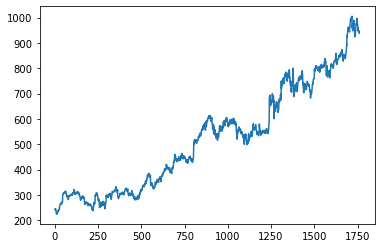

In [13]:
plt.plot(range(0, len(goog.Open)), goog.Open)

In [14]:
goog_open= goog["Open"].values
goog_close = goog["Close"].values

In [15]:
#Define trading environment
class TradingEnvironment():
    def __init__(self, data_open = goog_open, data_close = goog_close, series_length=200, starting_point=0):
        
        self.data_open = data_open
        self.data_close = data_close
        #Observation space [No.of shares, Cash in hand, next opening price, portfolio value, past 5 day average]
        self.state = torch.FloatTensor(torch.zeros(5))
        #Starting cash
        self.starting_cash = 6000
        #Length of time series
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        #Initial No.of shares
        self.state[0] = 20
        #Starting portfolio value
        self.starting_portfolio_value = self.portfolio_value()
        self.state[1] = self.starting_cash
        self.state[2] = self.data_open[self.cur_timestep]
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()
        #Inventory holds the price of bought stock
        self.inventory = []
        num = int(self.state[0].item())
        #Append current price for the initial stocks
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])

        self.done = False
        self.profit = 0
        
    def portfolio_value(self):#To calculate total portfolio value
        return (self.state[0] * self.data_close[self.cur_timestep]) + self.state[1]
    
    def next_opening_price(self):#Finding the next opening price
        step = self.cur_timestep + 1
        return self.data_open[step]
    
    def five_day_window(self):#past Five day average calc
        step = self.cur_timestep
        if step < 5:
            return self.data_open[0]
        goog5 = self.data_open[step-5:step].mean()
        return goog5
    
    def step(self, action):
        delta = 0
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        retval = None
        cur_value = self.portfolio_value()
        
        #Check if done
        if cur_timestep >= self.starting_point + (self.series_length):
            new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
            self.state = new_state
            if self.profit > 0:
                rew = 1
            else:
                rew = 0
            return new_state, rew, True, { "msg": "done"}
        #action ==2 ,Do nothing return the next state
        if action[0] == 2:
            new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
            self.state = new_state
            retval = new_state, 0, False, { "msg": "nothing" }
             
        #Action = 0, Buy, if there is enough cash in hand, and reward is 1 if bought for lower price than previous buy, else reward is 0    
        if action[0] == 0:
            if action[1] * self.data_open[cur_timestep] < self.state[1]:
                goog_shares = self.state[0] + action[1]
                cash_spent = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1]- cash_spent, self.next_opening_price(), cur_value, self.five_day_window()]
                self.state = new_state
                prev_price = self.inventory[-1]
                delt = prev_price - self.data_open[cur_timestep]
                self.state = new_state
                if delt > 0:
                    rew = 1
                else:
                    rew = 0
                self.inventory.append(self.data_open[self.cur_timestep])
                retval = new_state, rew, False, { "msg": "bought goog"}
            else:#If there is no enough cash in hand, end episode
                new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Bankrupt"}
                
        if action[0] == 1: #Action = 1, Sell, if there is enough stock, and reward is 1 if sold for higher price than bought, else reward is 0    
            if action[1] < self.state[0]:
                goog_shares = self.state[0] - action[1]
                cash_gained = action[1] * self.data_open[cur_timestep]
                new_state = [goog_shares, self.state[1] + cash_gained, self.next_opening_price(), cur_value, self.five_day_window()]
                bought_price = self.inventory.pop(0)
                delta = self.data_open[cur_timestep] - bought_price
                self.state = new_state
                if delta > 0:
                    rew = 1
                else:
                    rew = 0
                retval = new_state, rew, False, { "msg": "sold goog"}  
            else:#End episode if selling more than have
                new_state = [self.state[0], self.state[1],self.next_opening_price(), cur_value, self.five_day_window()]
                self.state = new_state
                retval = new_state, 0, True, { "msg": "Sold more than have"}
        #Calculate selling profit      
        self.profit += delta
        #Increase step
        self.cur_timestep += 1
        return retval
    
    def reset(self):#Reset observation space and timestep
        self.state = torch.FloatTensor(torch.zeros(5))
        self.starting_cash = 6000
        self.cur_timestep = self.starting_point
        self.state[0] = 20
        self.state[1] = self.starting_cash
        self.state[2] = self.data_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[3] = self.starting_portfolio_value
        self.state[4] = self.five_day_window()
        self.done = False
        self.inventory = []
        num = int(self.state[0].item())
        for i in range(num):
            self.inventory.append(self.data_open[self.cur_timestep])
        self.profit = 0

        return self.state

In [25]:
#Define actor critic neural network
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(5, 128)
        self.hidden_1 = nn.Linear(128, 32)
        self.hidden_2 = nn.Linear(32,31)
        #Actor Layer
        self.action_head = nn.Linear(31, 3)
        #Critic Layer
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []
        
    def forward(self, x):
        x = torch.tensor(x)
        x = torch.sigmoid(self.input_layer(x))
        x = F.relu(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        #Get an action
        action = m.sample()
        #If action is sell and no.of share is zero, force it to do nothing
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [9]:
#Define Environment, Agent, optimizer
env = TradingEnvironment(data_open = goog_open, data_close = goog_close, series_length= len(goog_open)-2)
model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [10]:
env.reset()
gamma = 0.988
#Log every 50 episode
log_interval = 100

#At the end of each episode update gardients
def finish_episode(episode):
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    returns = []
    #Calculate discounted reward
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        returns.insert(0, R)
        
    returns = torch.tensor(returns)

    #Standardize the discounted reward (Helps converge faster)
    eps = np.finfo(np.float32).eps.item()
    returns = (returns - returns.mean()) / (returns.std() + eps)

    #Calculate policy and value loss  
    for (log_prob, value), R in zip(saved_actions, returns):
        #Calculate advantage value
        advantage = torch.tensor(R - value.item())
        policy_losses.append(-log_prob * advantage)
        #Smooth L1 loss has the advantage of both L1 and L2 loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    #Reset gradients           
    optimizer.zero_grad()
    #Sum up policy and value losses
    loss = torch.stack(policy_losses).mean() + torch.stack(value_losses).mean()
    writer.add_scalar('Policy loss',torch.stack(policy_losses).mean(), episode)
    writer.add_scalar('Value loss',torch.stack(value_losses).mean(), episode)
    writer.add_scalar('Total loss',loss, episode)
    #Backpropogation
    loss.backward()
    optimizer.step()    
    #Delete saved rewards and actions
    del model.rewards[:]
    del model.saved_actions[:]

In [11]:
#Start training
running_reward = 100
#Train for 1000 episodes
for episode in range(0,2000):
    state = env.reset()
    done = False
    msg = None
    ep_rew = 0
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        #print(action,state,reward)
        model.rewards.append(reward)
        ep_rew += reward
        if done:
            break
    finish_episode(episode)
    running_reward = running_reward * (1 - 0.05) + ep_rew * (0.05)
     # ...log the running reward
    writer.add_scalar('Running reward',running_reward,episode)
    #stop training if the threshold is reached
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and reward == 1 and running_reward > 950:
        print("Early Stopping--- Profit :" + str(int(env.profit)))
        break
    #Log every 10 episodes
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, last reward {} \
episode reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, ep_rew, running_reward))

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 10925.0, finished at 13076.3 because Sold more than have @ t=579, last reward 0 episode reward 197.0, running reward 104.8
Episode 100: started at 10925.0, finished at 25616.1 because done @ t=1759, last reward 1 episode reward 663.0, running reward 355.4
Episode 200: started at 10925.0, finished at 22792.5 because done @ t=1759, last reward 1 episode reward 779.0, running reward 626.2
Episode 300: started at 10925.0, finished at 20516.7 because done @ t=1759, last reward 1 episode reward 809.0, running reward 758.7
Episode 400: started at 10925.0, finished at 21650.3 because done @ t=1759, last reward 1 episode reward 876.0, running reward 854.4
Episode 500: started at 10925.0, finished at 18035.9 because done @ t=1759, last reward 1 episode reward 891.0, running reward 915.0
Episode 600: started at 10925.0, finished at 23542.7 because done @ t=1759, last reward 1 episode reward 909.0, running reward 887.3
Episode 700: started at 10925.0, finished at 24841.1 beca

In [12]:
#Check out a sample run
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} shares, cash in hand is {} ".format(msg["msg"], next_state[0], next_state[1]))
    if msg["msg"] == "done":
        print("total portfolio value {}".format(env.portfolio_value()))
        break

starting portfolio value 10925.025390625
bought goog, have 21.0 shares, cash in hand is 5757.78759765625 
bought goog, have 22.0 shares, cash in hand is 5513.04296875 
bought goog, have 23.0 shares, cash in hand is 5270.9609375 
bought goog, have 24.0 shares, cash in hand is 5026.45166015625 
bought goog, have 25.0 shares, cash in hand is 4780.986328125 
sold goog, have 24.0 shares, cash in hand is 5021.73193359375 
sold goog, have 23.0 shares, cash in hand is 5255.951171875 
bought goog, have 24.0 shares, cash in hand is 5024.97021484375 
sold goog, have 23.0 shares, cash in hand is 5254.04931640625 
bought goog, have 24.0 shares, cash in hand is 5028.82421875 
bought goog, have 25.0 shares, cash in hand is 4800.56591796875 
sold goog, have 24.0 shares, cash in hand is 5027.072265625 
sold goog, have 23.0 shares, cash in hand is 5256.876953125 
bought goog, have 24.0 shares, cash in hand is 5031.5966796875 
sold goog, have 23.0 shares, cash in hand is 5259.314453125 
bought goog, have

C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


sold goog, have 22.0 shares, cash in hand is 5985.359375 
sold goog, have 21.0 shares, cash in hand is 6293.06689453125 
sold goog, have 20.0 shares, cash in hand is 6602.23095703125 
sold goog, have 19.0 shares, cash in hand is 6912.2158203125 
bought goog, have 20.0 shares, cash in hand is 6603.421875 
bought goog, have 21.0 shares, cash in hand is 6294.4130859375 
sold goog, have 20.0 shares, cash in hand is 6607.75634765625 
bought goog, have 21.0 shares, cash in hand is 6286.375 
sold goog, have 20.0 shares, cash in hand is 6602.79638671875 
bought goog, have 21.0 shares, cash in hand is 6282.6865234375 
bought goog, have 22.0 shares, cash in hand is 5978.59765625 
bought goog, have 23.0 shares, cash in hand is 5674.193359375 
bought goog, have 24.0 shares, cash in hand is 5363.7177734375 
sold goog, have 23.0 shares, cash in hand is 5672.97216796875 
sold goog, have 22.0 shares, cash in hand is 5982.81689453125 
bought goog, have 23.0 shares, cash in hand is 5680.71484375 
sold g

bought goog, have 29.0 shares, cash in hand is 4456.5224609375 
bought goog, have 30.0 shares, cash in hand is 4135.45654296875 
bought goog, have 31.0 shares, cash in hand is 3814.125244140625 
sold goog, have 30.0 shares, cash in hand is 4140.921875 
bought goog, have 31.0 shares, cash in hand is 3808.073974609375 
bought goog, have 32.0 shares, cash in hand is 3476.677490234375 
sold goog, have 31.0 shares, cash in hand is 3806.58251953125 
sold goog, have 30.0 shares, cash in hand is 4130.15625 
bought goog, have 31.0 shares, cash in hand is 3814.966064453125 
bought goog, have 32.0 shares, cash in hand is 3502.904052734375 
sold goog, have 31.0 shares, cash in hand is 3818.830078125 
sold goog, have 30.0 shares, cash in hand is 4132.2734375 
sold goog, have 29.0 shares, cash in hand is 4448.57958984375 
bought goog, have 30.0 shares, cash in hand is 4134.951171875 
sold goog, have 29.0 shares, cash in hand is 4455.76708984375 
bought goog, have 30.0 shares, cash in hand is 4160.20

bought goog, have 29.0 shares, cash in hand is 4362.7626953125 
bought goog, have 30.0 shares, cash in hand is 4030.555419921875 
bought goog, have 31.0 shares, cash in hand is 3698.7236328125 
bought goog, have 32.0 shares, cash in hand is 3368.06298828125 
sold goog, have 31.0 shares, cash in hand is 3693.38818359375 
bought goog, have 32.0 shares, cash in hand is 3370.06982421875 
bought goog, have 33.0 shares, cash in hand is 3041.8916015625 
bought goog, have 34.0 shares, cash in hand is 2706.801513671875 
sold goog, have 33.0 shares, cash in hand is 3041.63134765625 
sold goog, have 32.0 shares, cash in hand is 3376.95166015625 
sold goog, have 31.0 shares, cash in hand is 3710.505126953125 
sold goog, have 30.0 shares, cash in hand is 4040.92041015625 
sold goog, have 29.0 shares, cash in hand is 4375.259765625 
sold goog, have 28.0 shares, cash in hand is 4719.494140625 
sold goog, have 27.0 shares, cash in hand is 5065.4951171875 
bought goog, have 28.0 shares, cash in hand is

bought goog, have 27.0 shares, cash in hand is 4766.7431640625 
sold goog, have 26.0 shares, cash in hand is 5213.68505859375 
bought goog, have 27.0 shares, cash in hand is 4724.90625 
bought goog, have 28.0 shares, cash in hand is 4218.669921875 
bought goog, have 29.0 shares, cash in hand is 3715.6669921875 
bought goog, have 30.0 shares, cash in hand is 3214.666015625 
sold goog, have 29.0 shares, cash in hand is 3731.117431640625 
sold goog, have 28.0 shares, cash in hand is 4246.04248046875 
sold goog, have 27.0 shares, cash in hand is 4754.150390625 
sold goog, have 26.0 shares, cash in hand is 5264.21044921875 
sold goog, have 25.0 shares, cash in hand is 5783.44482421875 
sold goog, have 24.0 shares, cash in hand is 6298.4248046875 
bought goog, have 25.0 shares, cash in hand is 5782.01318359375 
bought goog, have 26.0 shares, cash in hand is 5265.7470703125 
bought goog, have 27.0 shares, cash in hand is 4755.0615234375 
sold goog, have 26.0 shares, cash in hand is 5268.375 


sold goog, have 20.0 shares, cash in hand is 8028.89306640625 
bought goog, have 21.0 shares, cash in hand is 7441.4033203125 
sold goog, have 20.0 shares, cash in hand is 8028.203125 
sold goog, have 19.0 shares, cash in hand is 8606.203125 
sold goog, have 18.0 shares, cash in hand is 9190.302734375 
sold goog, have 17.0 shares, cash in hand is 9780.2529296875 
bought goog, have 18.0 shares, cash in hand is 9195.3525390625 
bought goog, have 19.0 shares, cash in hand is 8620.5625 
bought goog, have 20.0 shares, cash in hand is 8038.95263671875 
sold goog, have 19.0 shares, cash in hand is 8606.4228515625 
bought goog, have 20.0 shares, cash in hand is 8051.29296875 
sold goog, have 19.0 shares, cash in hand is 8601.4326171875 
bought goog, have 20.0 shares, cash in hand is 8059.3525390625 
bought goog, have 21.0 shares, cash in hand is 7532.3525390625 
sold goog, have 20.0 shares, cash in hand is 8072.802734375 
bought goog, have 21.0 shares, cash in hand is 7552.3525390625 
bought g

bought goog, have 23.0 shares, cash in hand is 6467.912109375 
sold goog, have 22.0 shares, cash in hand is 7011.33203125 
bought goog, have 23.0 shares, cash in hand is 6465.6318359375 
sold goog, have 22.0 shares, cash in hand is 7020.1220703125 
sold goog, have 21.0 shares, cash in hand is 7567.27197265625 
bought goog, have 22.0 shares, cash in hand is 7024.5419921875 
sold goog, have 21.0 shares, cash in hand is 7569.02197265625 
bought goog, have 22.0 shares, cash in hand is 7023.60205078125 
bought goog, have 23.0 shares, cash in hand is 6475.60205078125 
sold goog, have 22.0 shares, cash in hand is 7032.1220703125 
sold goog, have 21.0 shares, cash in hand is 7591.5322265625 
sold goog, have 20.0 shares, cash in hand is 8151.322265625 
bought goog, have 21.0 shares, cash in hand is 7588.84228515625 
sold goog, have 20.0 shares, cash in hand is 8149.14208984375 
bought goog, have 21.0 shares, cash in hand is 7589.43212890625 
sold goog, have 20.0 shares, cash in hand is 8136.182

bought goog, have 18.0 shares, cash in hand is 9934.34765625 
bought goog, have 19.0 shares, cash in hand is 9163.087890625 
bought goog, have 20.0 shares, cash in hand is 8362.587890625 
sold goog, have 19.0 shares, cash in hand is 9148.8681640625 
bought goog, have 20.0 shares, cash in hand is 8404.2783203125 
bought goog, have 21.0 shares, cash in hand is 7678.7783203125 
sold goog, have 20.0 shares, cash in hand is 8366.4580078125 
bought goog, have 21.0 shares, cash in hand is 7673.5078125 
bought goog, have 22.0 shares, cash in hand is 6961.7177734375 
sold goog, have 21.0 shares, cash in hand is 7658.0576171875 
sold goog, have 20.0 shares, cash in hand is 8370.267578125 
sold goog, have 19.0 shares, cash in hand is 9088.91796875 
bought goog, have 20.0 shares, cash in hand is 8361.91796875 
sold goog, have 19.0 shares, cash in hand is 9095.8779296875 
bought goog, have 20.0 shares, cash in hand is 8379.9775390625 
bought goog, have 21.0 shares, cash in hand is 7650.4677734375 


bought goog, have 26.0 shares, cash in hand is 3858.43798828125 
sold goog, have 25.0 shares, cash in hand is 4680.8681640625 
sold goog, have 24.0 shares, cash in hand is 5491.73828125 
sold goog, have 23.0 shares, cash in hand is 6298.498046875 
sold goog, have 22.0 shares, cash in hand is 7082.998046875 
sold goog, have 21.0 shares, cash in hand is 7854.2978515625 
bought goog, have 22.0 shares, cash in hand is 7059.34765625 
bought goog, have 23.0 shares, cash in hand is 6257.3173828125 
bought goog, have 24.0 shares, cash in hand is 5455.4873046875 
sold goog, have 23.0 shares, cash in hand is 6265.4873046875 
bought goog, have 24.0 shares, cash in hand is 5488.67724609375 
sold goog, have 23.0 shares, cash in hand is 6260.4375 
bought goog, have 24.0 shares, cash in hand is 5494.9677734375 
bought goog, have 25.0 shares, cash in hand is 4724.5478515625 
sold goog, have 24.0 shares, cash in hand is 5507.0478515625 
bought goog, have 25.0 shares, cash in hand is 4719.8779296875 
bo

sold goog, have 20.0 shares, cash in hand is 8838.33984375 
sold goog, have 19.0 shares, cash in hand is 9832.439453125 
bought goog, have 20.0 shares, cash in hand is 8861.7392578125 
bought goog, have 21.0 shares, cash in hand is 7888.958984375 
sold goog, have 20.0 shares, cash in hand is 8858.138671875 
sold goog, have 19.0 shares, cash in hand is 9806.12890625 
bought goog, have 20.0 shares, cash in hand is 8846.12890625 
bought goog, have 21.0 shares, cash in hand is 7898.31884765625 
sold goog, have 20.0 shares, cash in hand is 8846.6884765625 
bought goog, have 21.0 shares, cash in hand is 7897.58837890625 
sold goog, have 20.0 shares, cash in hand is 8841.5380859375 
sold goog, have 19.0 shares, cash in hand is 9789.05859375 
done, have 19.0 shares, cash in hand is 9789.05859375 
total portfolio value 27728.66796875


In [13]:
#save model
torch.save(model.state_dict(),'./AC_model_1')

In [26]:
#Load saved model
model = Policy()
model.load_state_dict(torch.load('./AC_model_1'))

<All keys matched successfully>

#### Testing on Google_2019 dataset

In [5]:
#Load test dataset
te_goog = pd.read_csv('GOOG_2019.csv')

In [6]:
te_goog.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
1,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
2,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
4,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900


In [7]:
te_goog.Date = pd.to_datetime(te_goog.Date)

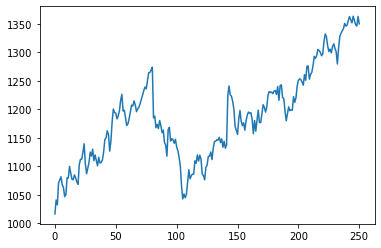

In [8]:
plt.plot(range(0,len( te_goog.Open)),  te_goog.Open)

In [28]:
#Pass test data to the trading environment
env = TradingEnvironment(data_open=te_goog.Open, data_close = te_goog.Close, series_length=len(te_goog.Close)-2)
env.reset()
state = env.reset()
reward = 0
done = False
msg = None
#Create empty lists to store the action times
bg_action_times = []
sg_action_times = []
n_action_times = []
nothing_at = []
print('Starting Portfolio value :',env.portfolio_value().item())
while not done:
    action = model.act(state)
    if action == 0:
        bg_action_times.append(env.cur_timestep)
    if action == 1:
        sg_action_times.append(env.cur_timestep)
    if action == 2:
        n_action_times.append(env.cur_timestep)
    state, reward, done, msg = env.step(action)
    model.rewards.append(reward)
if msg["msg"] == "done":
        print("Have {} shares and ${} cash. selling profit: {}, Total portfolio value: {}".format(state[0], state[1],env.profit, env.portfolio_value()))
    

Starting Portfolio value : 26917.0


C:\Users\Thasleem\anaconda3\envs\cmpe_255\lib\site-packages\ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Have 19.0 shares and $6316.4951171875 cash. selling profit: 5061.965648999998, Total portfolio value: 32002.40625


In [29]:
#Get date and open price of buy sell actions from timestamps for plotting
buy_date = [te_goog.Date[x] for x in bg_action_times]
sell_date = [te_goog.Date[x] for x in sg_action_times]
bought_goog_at = [te_goog.Open[x] for x in bg_action_times]
sold_goog_at = [te_goog.Open[x] for x in sg_action_times]

In [55]:
# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go
fig = px.line(te_goog, x='Date', y='Open')
fig.add_trace(go.Scatter(x = buy_date,y = bought_goog_at, mode="markers",showlegend=True,name="Buy"))
fig.add_trace(go.Scatter(x = sell_date,y = sold_goog_at, mode="markers",showlegend=True,name="Sell"))
fig.update_layout(title="Test results on Goog_2019", annotations=[dict(text='Selling profit :' +str(env.profit.round()) + ',<br>End portfolio value :' +str(env.portfolio_value().round().item()),
                showarrow=False, xref='paper',yref='paper', x=0.1, y=0.9, font=dict(size=16))])
fig.show()